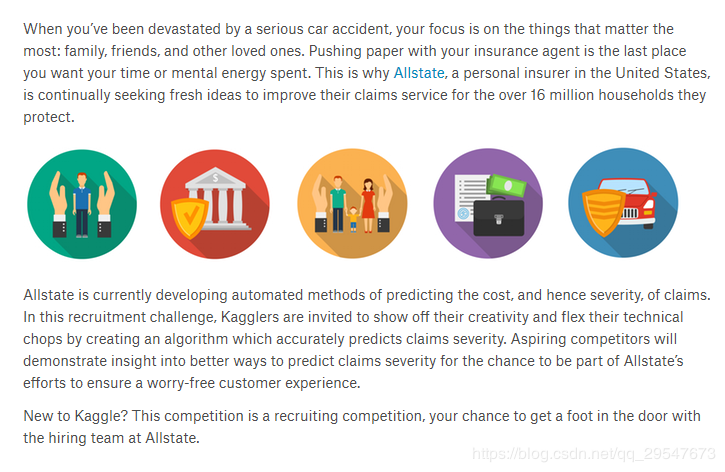

In [82]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import KFold,train_test_split

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'


## 数据预处理

In [30]:
train = pd.read_csv('allstate-claims-severity/train.csv')

In [31]:
train['log_loss']=np.log(train['loss'])

In [32]:
features = [x for x in train.columns if x not in ['id','loss','log_loss']]

cat_features =[x for x in train.select_dtypes(include = ['object']) if x not in ['id','loss','log_loss']]

num_features =[x for x in train.select_dtypes(exclude = ['object']) if x not in ['id','loss','log_loss']]           

print('离散特征Categorical: {} features'.format(len(cat_features)))
print('Numerical:{} features'.format(len(num_features)))
features

离散特征Categorical: 116 features
Numerical:14 features


['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18',
 'cat19',
 'cat20',
 'cat21',
 'cat22',
 'cat23',
 'cat24',
 'cat25',
 'cat26',
 'cat27',
 'cat28',
 'cat29',
 'cat30',
 'cat31',
 'cat32',
 'cat33',
 'cat34',
 'cat35',
 'cat36',
 'cat37',
 'cat38',
 'cat39',
 'cat40',
 'cat41',
 'cat42',
 'cat43',
 'cat44',
 'cat45',
 'cat46',
 'cat47',
 'cat48',
 'cat49',
 'cat50',
 'cat51',
 'cat52',
 'cat53',
 'cat54',
 'cat55',
 'cat56',
 'cat57',
 'cat58',
 'cat59',
 'cat60',
 'cat61',
 'cat62',
 'cat63',
 'cat64',
 'cat65',
 'cat66',
 'cat67',
 'cat68',
 'cat69',
 'cat70',
 'cat71',
 'cat72',
 'cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 'cat101

In [33]:
ntrain = train.shape[0]
#ntrain = 188318

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
print('Xtrain:',train_x.shape)
print('ytrain:',train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


In [38]:
train_x

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0,1,0,0,0,0,0,0,1,0,...,0.939556,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216
188314,0,0,0,0,0,1,0,0,0,0,...,0.704268,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872
188315,0,1,0,0,0,0,0,1,1,0,...,0.482436,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888
188316,0,1,0,0,0,0,0,0,1,1,...,0.340543,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707


## Simple XGBoost Model
    首先，我们训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差衡量mean_absolute_error(np.exp(y),np.exp(yhat))
    xgboost自定义一个数据矩阵类DMatrix，会在训练开始时，进行一边预处理，从而提高之后每次迭代的效率
### 结果衡量方法

In [34]:
#评估策略，e的次幂，用来评估。
#结果衡量方法：使用平均绝对误差来衡量
#mean_absolute_error(np.exp(y), np.exp(yhat))。
#定义计算损失值的函数
def xg_eval_mae(yhat,dtrain):
    y = dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))

### Model

In [36]:
#数据类型转换成库可以使用的底层格式。
dtrain = xgb.DMatrix(train_x,train['log_loss'])
dtrain

# Xgboost参数  
         
    ·'booster':'gbtree',梯度提升树
    ·'objective': 'multi:softmax', 多分类的问题  
    ·'num_class':10, 类别数，与 multisoftmax 并用
    ·'gamma':损失下降多少才进行分裂
    ·'max_depth':12, 构建树的深度，越大越容易过拟合
    ·'lambda':2, 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    ·'subsample':0.7, 随机采样训练样本 // 取70%的数据训练
    ·'colsample_bytree':0.7, 生成树时进行的列采样
    ·'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
    ·'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
    ·'eta': 0.007, 如同学习率。//后加树 的贡献率
    ·'seed':1000,
    ·'nthread':7, cpu 线程数
————————————————  
版权声明：本文为CSDN博主「好瘦的小胖子」的原创文章，遵循 CC 4.0 BY-SA 版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/qq_29547673/article/details/89319061

In [39]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

使用交叉验证 xgb.cv

In [40]:
%%time

#feval:评估策略
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1220.110026
Wall time: 26 s


<Figure size 432x288 with 0 Axes>

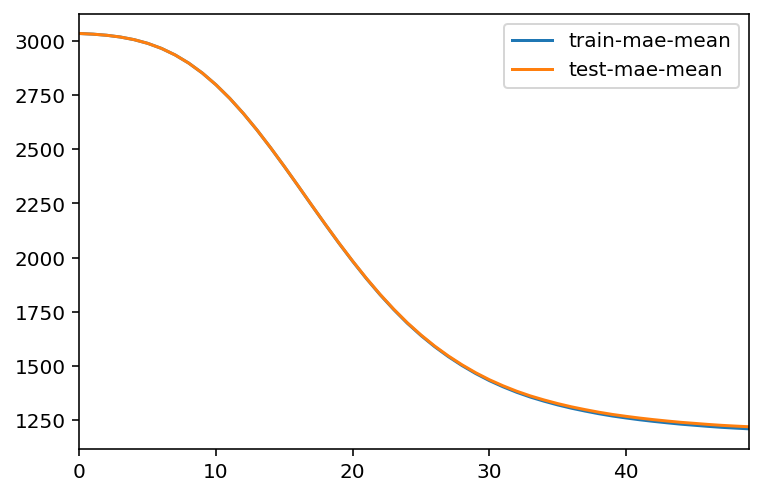

In [41]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot() 

## 上面是我们第一个模型
    ·没有发生过拟合  
    ·只建立了50个树模型

In [42]:
%%time
#建立100个树模型
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 1172.059570333333
Wall time: 50.9 s


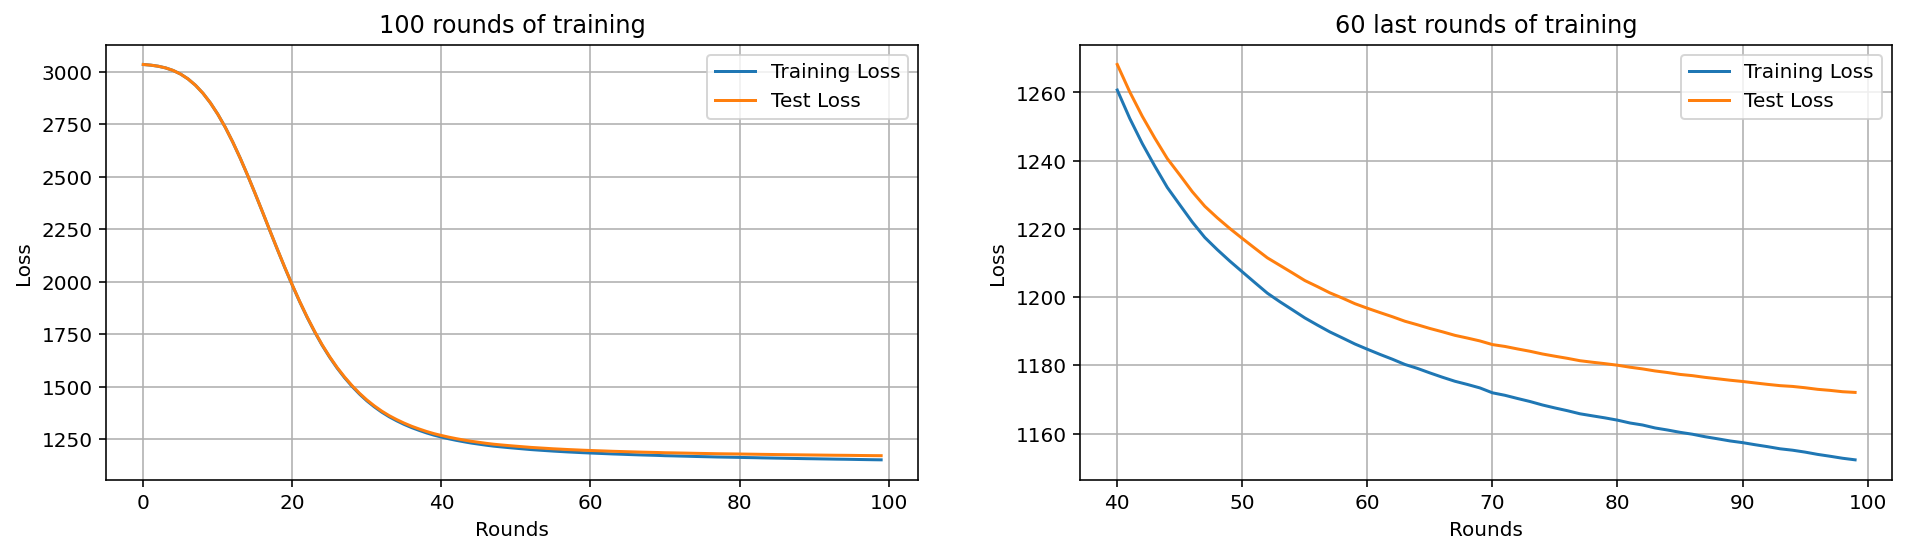

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss']) 

    我们把树模型的数量增加到了100。效果不是很明显。看最后的60次。我们可以看到 测试集仅比训练集高那么一丁点。存在一丁点的过拟合。
    不过我们的CV score更低了。接下来，我们改变其他参数。

## XGBoost 参数调节
    Step 1: 选择一组初始参数
    Step 2: 改变 max_depth 和 min_child_weight.
    Step 3: 调节 gamma 降低模型过拟合风险.
    Step 4: 调节 subsample 和 colsample_bytree 改变数据采样策略.
    Step 5: 调节学习率 eta.

In [89]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})#默认参数
        
    def fit(self, x_train, y_train):
        '''
        #数据类型转换,#用参数去训练xgboost模型
        '''
        dtrain = xgb.DMatrix(x_train, y_train) 
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self 


In [48]:
#衡量标准
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [90]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

In [91]:
bst.kfold(train_x, train_y, nfold=5)

train-rmse-mean       0.558938
train-rmse-std        0.001005
test-rmse-mean        0.562665
test-rmse-std         0.002445
train-mae-mean     1209.707324
train-mae-std         3.004207
test-mae-mean      1218.884204
test-mae-std          8.982969
Name: 49, dtype: float64

### 按照训练集处理方式，处理我们的测试集

In [59]:
test = pd.read_csv('allstate-claims-severity/test.csv')

test#没有loss列,loss需要预测

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,587617,A,A,A,B,A,A,A,A,A,...,0.281143,0.438917,0.815941,0.39455,0.48740,0.40666,0.550529,0.538473,0.298734,0.345946
125542,587621,A,A,A,A,B,B,A,B,A,...,0.674529,0.346948,0.424968,0.47669,0.25753,0.26894,0.324486,0.352251,0.490001,0.290576
125543,587627,B,B,A,A,B,A,A,A,B,...,0.794794,0.808958,0.511502,0.72299,0.94438,0.83510,0.933174,0.926619,0.848129,0.808125
125544,587629,A,A,A,A,A,B,A,B,A,...,0.302678,0.372125,0.388545,0.31796,0.32128,0.36974,0.307628,0.301921,0.608259,0.361542


In [76]:
#features_test = [x for x in test.columns if x not in ['id']]

test_x = test[features]

#将类别数据的类别用数字替换
for c in range(len(cat_features)):

    test_x[cat_features[c]] = test_x[cat_features[c]].astype('category').cat.codes

test_x.head()


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,0,0,0,0,0,1,0,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,0,1,0,1,0,0,0,0,1,0,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,0,1,0,1,1,0,1,0,1,1,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,0,0,0,0,1,0,0,0,0,0,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,1,0,0,0,0,1,0,0,0,0,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


In [92]:
#数据类型转换成库可以使用的底层格式。
dtest_x = xgb.DMatrix(test_x)
#dtest_x
#得到我们想要的测试集


#预测命令：
#xgb.predict(dtest_x)
test_y = bst.predict(test_x)

In [101]:
test_y[1],len(test_y)

(7.450635, 125546)

In [109]:
import math

#math.exp(test_y[0])
test_exp_y= np.zeros(len(test_y))
for i in range(len(test_y)):
    test_exp_y[i] = math.exp(test_y[i])
test_exp_y.shape

(125546,)

## Step 1: 基准模型
## Step 2: 树的深度与节点权重
这些参数对xgboost性能影响最大，因此，他们应该调整第一。我们简要地概述它们：  
    max_depth: 树的最大深度。增加这个值会使模型更加复杂，也容易出现过拟合，深度3-10是合理的。  
    min_child_weight: 正则化参数. 如果树分区中的实例权重小于定义的总和，则停止树构建过程。
    

In [51]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth'] 

[4, 5, 6, 7, 8]

In [53]:
%%time
from sklearn.model_selection import GridSearchCV

#交叉验证 网格搜索
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring = mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 18min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<__main__.XGBoostRegressor object at 0x000001EAF043AAC8>,
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_score, greater_is_better=False),
             verbose=0)

In [74]:
#grid.grid_scores_, grid.best_params_, grid.best_score_  #旧版本

#print(grid.cv_results_)#新版本
print(grid.cv_results_['mean_test_score'])
print(grid.cv_results_['params'])
print('************************************')
print(grid.best_params_)
print('************************************')
print(grid.best_score_ )

[-1243.45883654 -1243.43443586 -1243.74273371 -1219.45710638
 -1219.53921994 -1219.59817312 -1205.01504313 -1203.69057513
 -1203.64737075 -1194.79949665 -1194.31288936 -1193.77942991
 -1189.22162241 -1188.18115104 -1187.53612533]
[{'max_depth': 4, 'min_child_weight': 1}, {'max_depth': 4, 'min_child_weight': 3}, {'max_depth': 4, 'min_child_weight': 6}, {'max_depth': 5, 'min_child_weight': 1}, {'max_depth': 5, 'min_child_weight': 3}, {'max_depth': 5, 'min_child_weight': 6}, {'max_depth': 6, 'min_child_weight': 1}, {'max_depth': 6, 'min_child_weight': 3}, {'max_depth': 6, 'min_child_weight': 6}, {'max_depth': 7, 'min_child_weight': 1}, {'max_depth': 7, 'min_child_weight': 3}, {'max_depth': 7, 'min_child_weight': 6}, {'max_depth': 8, 'min_child_weight': 1}, {'max_depth': 8, 'min_child_weight': 3}, {'max_depth': 8, 'min_child_weight': 6}]
************************************
{'max_depth': 8, 'min_child_weight': 6}
************************************
-1187.5361253348233


网格搜索发现的最佳结果:
{'max_depth': 8, 'min_child_weight': 6}, -1187.9597499123447)

In [ ]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])] 

In [ ]:
_,scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

In [ ]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

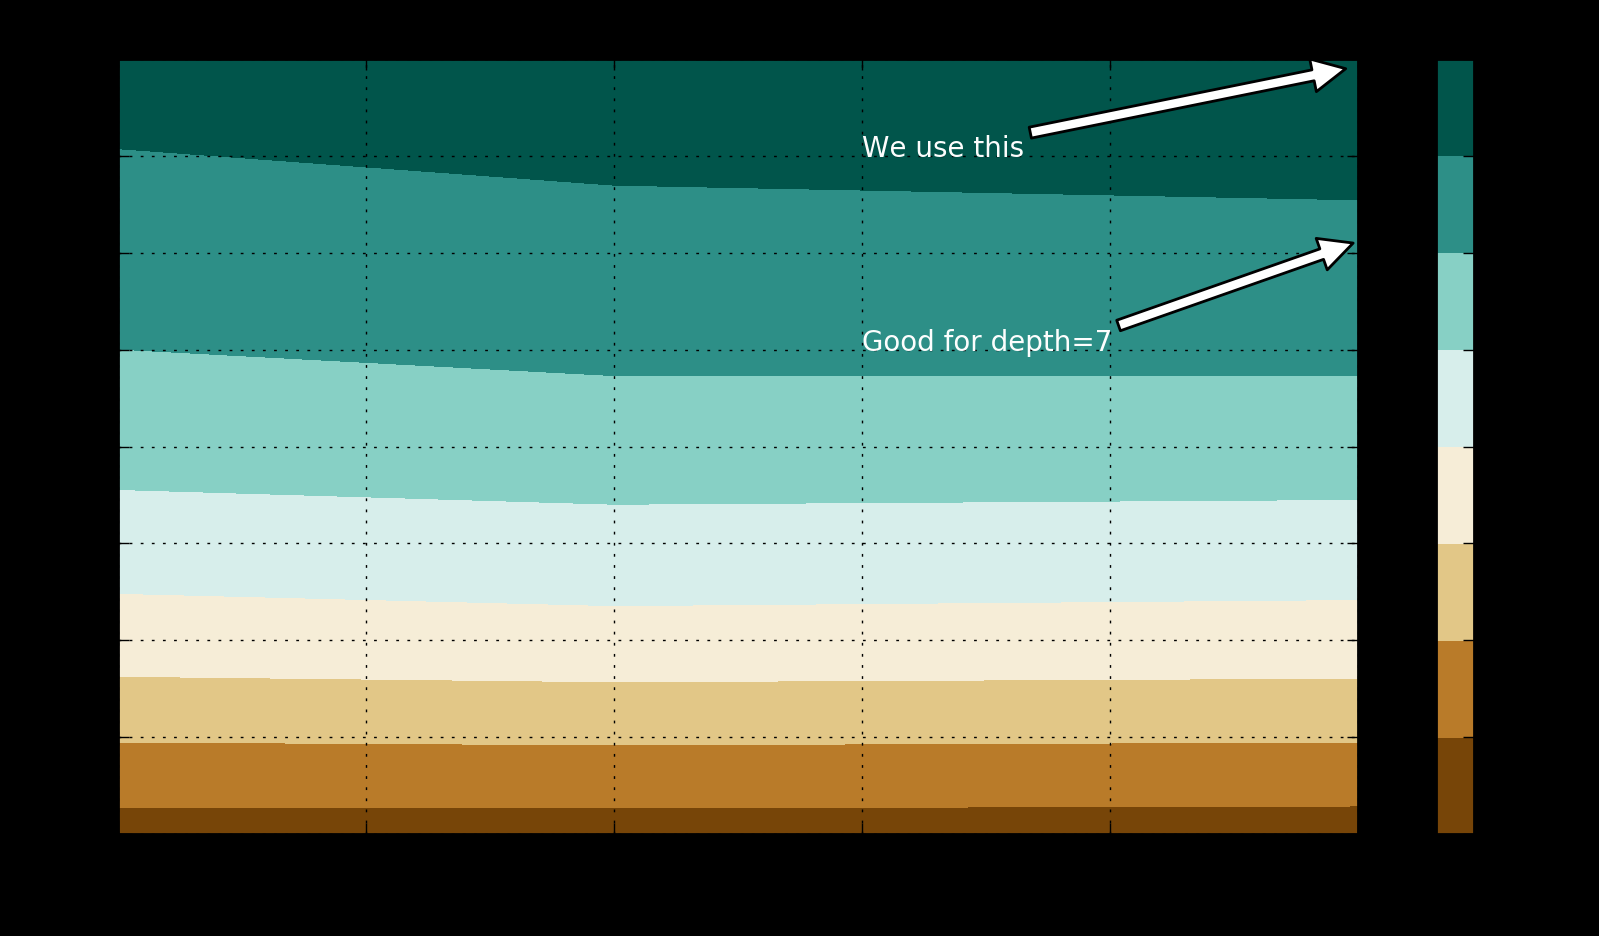

## Step 3: 调节 gamma去降低过拟合风险

In [ ]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

#Wall time: 13min 45s

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_ 

## Step 4: 调节样本采样方式 subsample 和 colsample_bytree

In [ ]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

# Wall time: 28min 26s

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_ 

In [ ]:
_, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(3,3)

In [ ]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show() 

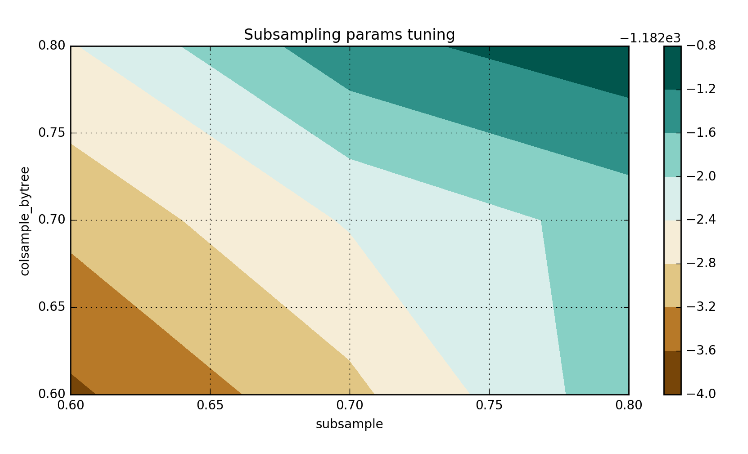

在当前的预训练模式的具体案例，我得到了下面的结果：
`{'colsample_bytree': 0.8, 'subsample': 0.8}, -1182.9309918891634)

## Step 5: 减小学习率并增大树个数
（也可以增大学习率减小树个数）
 
参数优化的最后一步是降低学习速度，同时增加更多的估计量
 
First, we plot different learning rates for a simpler model (50 trees):

In [ ]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values) 

#CPU times: user 6.69 ms, sys: 0 ns, total: 6.69 ms
#Wall time: 6.55 ms

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_ 

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

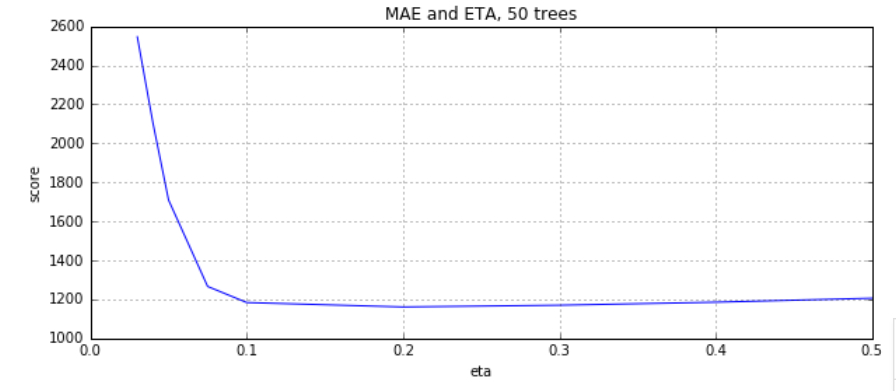

{'eta': 0.2}, -1160.9736284869114 是目前最好的结果  
现在我们把树的个数增加到100

In [ ]:
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_ 

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

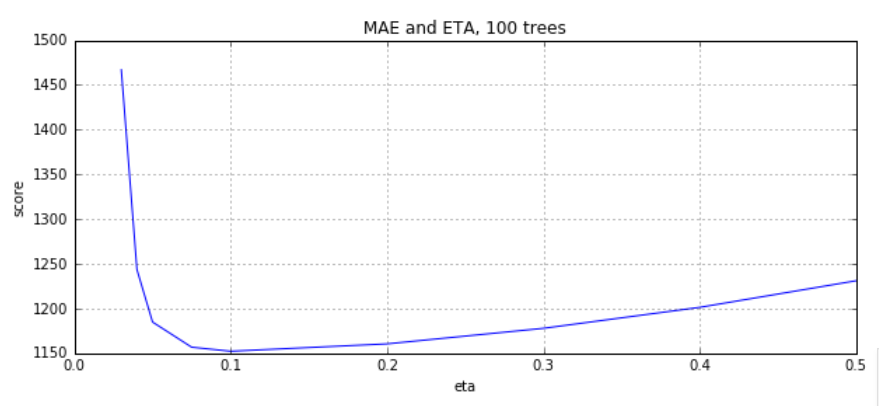  

学习率低一些的效果更好  

### 我们继续增大树的个数

In [ ]:
%%time

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

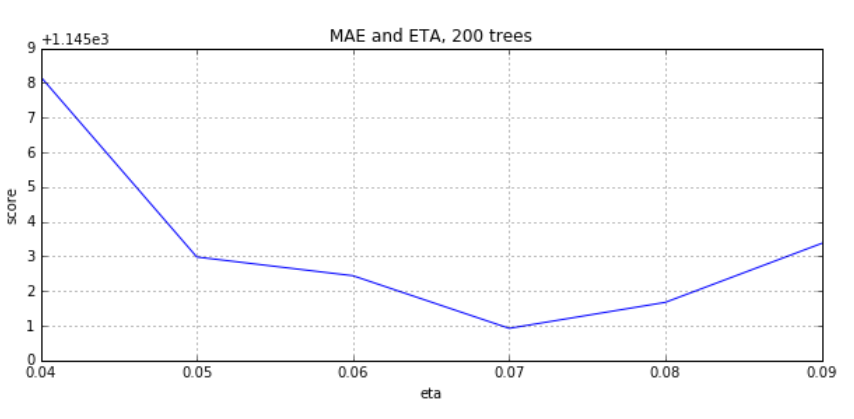

In [ ]:
%%time

# Final XGBoost model

bst = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(train_x, train_y, nfold=5)

In [ ]:
cv

## 总结
    可以看到200棵树最好的ETA是0.07。正如我们所预料的那样，ETA和num_boost_round依赖关系不是线性的，但是有些关联。
    花了相当长的一段时间优化xgboost. 从初始值: 1219.57. 经过调参之后达到 MAE=1171.77.
    我们还发现参数之间的关系ETA和num_boost_round：
    100 trees, eta=0.1: MAE=1152.247
    200 trees, eta=0.07: MAE=1145.92
`XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
colsample_bytree=0.6, subsample=0.9, eta=0.07).
xgboost作为kaggle和天池等各种数据比赛最受欢迎的算法之一,从项目中可见调参也是一件很容易的事情,并不复杂,好用精确率高,叫谁谁不用,